### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from model import UNet_baysian
from utils import make_one_hot, generate_target, generate_target_swap
from attack import DAG
from random import randint

### Hyperparamters for the attack

In [2]:
num_iterations=30
gamma=0.5
# num=15

### Loading model and inputs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=UNet_baysian()
model=model.to(device)
pretrained = True

In [4]:
#Load Entire Data
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import glob

class OASISDatasetTrain(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject_dir = os.path.join(self.root_dir, self.subjects[idx])
        # print(subject_dir)

        # Load and transform the images
        if self.transform:
            transform_images = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                # transforms.Normalize([0.5], [0.5])
            ])

            transform_labels = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 14).long()),
                transforms.Lambda(lambda x: torch.eye(15)[x].permute(3, 0, 1, 2))
            ])
            
            imageFilenamesList = glob.glob(subject_dir+'/PROCESSED/MPRAGE/T88_111/*t88_gfc_tra_90.gif')
            img_path = imageFilenamesList[0]
            images = Image.open(img_path)
            images = transform_images(images)
            
            labelFilenamesList = glob.glob(subject_dir+'/FSL_SEG/*gfc_fseg_tra_90.gif')
            label_path = labelFilenamesList[0]
            label = Image.open(label_path)
            label = transform_labels(label)

        return images, label

# Define the transformations to apply to the images
transform = transforms.Resize((256, 256))

# Create a DataLoader instance
root_dir = "datasets/OASIS_full/disc1"
dataset = OASISDatasetTrain(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)


In [5]:
#Train Model
# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


**Training**

In [6]:
if pretrained is False:
    model = torch.load(open("checkpoints/custom_trained",'rb'))
else:
    # Train model
    from torch.autograd import Variable
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training loop
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # input(inputs.shape)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets.squeeze(dim=2).float())

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

        # Print progress
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))
    torch.save(model, "checkpoints/custom_trained")

Epoch [1/100], Loss: 0.1135
Epoch [2/100], Loss: 0.0627
Epoch [3/100], Loss: 0.0595
Epoch [4/100], Loss: 0.0476
Epoch [5/100], Loss: 0.0407
Epoch [6/100], Loss: 0.0440
Epoch [7/100], Loss: 0.0382
Epoch [8/100], Loss: 0.0384
Epoch [9/100], Loss: 0.0416
Epoch [10/100], Loss: 0.0352
Epoch [11/100], Loss: 0.0371
Epoch [12/100], Loss: 0.0343
Epoch [13/100], Loss: 0.0365
Epoch [14/100], Loss: 0.0356
Epoch [15/100], Loss: 0.0364
Epoch [16/100], Loss: 0.0351
Epoch [17/100], Loss: 0.0328
Epoch [18/100], Loss: 0.0332
Epoch [19/100], Loss: 0.0323
Epoch [20/100], Loss: 0.0309
Epoch [21/100], Loss: 0.0331
Epoch [22/100], Loss: 0.0405
Epoch [23/100], Loss: 0.0835
Epoch [24/100], Loss: 0.0821
Epoch [25/100], Loss: 0.0287
Epoch [26/100], Loss: 0.0328
Epoch [27/100], Loss: 0.0283
Epoch [28/100], Loss: 0.0281
Epoch [29/100], Loss: 0.0288
Epoch [30/100], Loss: 0.0327
Epoch [31/100], Loss: 0.0344
Epoch [32/100], Loss: 0.0299
Epoch [33/100], Loss: 0.0338
Epoch [34/100], Loss: 0.0923
Epoch [35/100], Loss: 0

**Attack requires different trasforms to be applied**

In [7]:
#Load Entire Data for attack
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import glob

class OASISDatasetAttack(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject_dir = os.path.join(self.root_dir, self.subjects[idx])

        # Load and transform the images
        if self.transform:
            transform_images = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                # transforms.Normalize([0.5], [0.5])
            ])

            transform_labels = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 14).long()),
                # transforms.Lambda(lambda x: torch.eye(15)[x].permute(3, 0, 1, 2))
            ])
            
            imageFilenamesList = glob.glob(subject_dir+'/PROCESSED/MPRAGE/T88_111/*t88_gfc_tra_90.gif')
            img_path = imageFilenamesList[0]
            images = Image.open(img_path)
            images = transform_images(images)
            
            labelFilenamesList = glob.glob(subject_dir+'/FSL_SEG/*gfc_fseg_tra_90.gif')
            label_path = labelFilenamesList[0]
            label = Image.open(label_path)
            label = transform_labels(label)

        return images, label

# Define the transformations to apply to the images
transform = transforms.Resize((256, 256))

# Create a DataLoader instance
root_dir = "datasets/OASIS_full/disc1"
test_root_dir = "datasets/OASIS_full/disc5"
# dataset = OASISDatasetAttack(root_dir, transform=transform)
test_dataset = OASISDatasetAttack(test_root_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)


# Adversarial Evaluation vs Ground Truth and Original prediction vs ground truth

In [8]:
from medpy import metric
def calculate_metric_percase(pred,gt):
    pred[pred>0] = 1
    gt[gt>0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred,gt)
        hd95 = metric.binary.hd95(pred,gt)
        return dice,hd95
    elif pred.sum() > 0 and gt.sum()==0:
        return 1,0
    else:
        return 0,0

In [46]:
from collections import defaultdict
# len(test_dataset)
dices = defaultdict(list)
dices_clean = defaultdict(list)
hds = defaultdict(list)
hds_clean = defaultdict(list)
for i in range(len(test_dataset)):
    image,label=test_dataset[i]#image_all[idx],label_all[idx]
    image = image.unsqueeze(dim=0)
    
    image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
    image , label = image.to(device), label.to(device)
    
    label_oh = make_one_hot(label.long(),15,device)
    
    adv_target=generate_target_swap(label_oh.cpu().numpy())
    adv_target=torch.from_numpy(adv_target).float()
    adv_target=adv_target.to(device)
    
    _, adv=torch.max(adv_target,1)
    adv=adv.cpu().numpy()
    
    image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=int(num_iterations),
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

    for j in range(0,15):
        dice, hd = calculate_metric_percase(prediction_iteration[-1] == j, label[0].cpu().numpy() == j)
        dices[j].append(dice)
        hds[j].append(hd)
        dice, hd = calculate_metric_percase(prediction_iteration[0] == j, label[0].cpu().numpy() == j)
        dices_clean[j].append(dice)
        hds_clean[j].append(hd)

/tmp/ipykernel_28018/995846072.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()


Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient


In [47]:
sum_dice = 0
sum_hd = 0
sum_dice_clean = 0
sum_hd_clean = 0
for k in dices.keys():
    # print(k)
    dice_per_class = np.mean(dices[k])
    hd_per_class = np.mean(hds[k])
    sum_dice += dice_per_class
    sum_hd += hd_per_class
    dice_per_class = np.mean(dices_clean[k])
    hd_per_class = np.mean(hds_clean[k])
    sum_dice_clean += dice_per_class
    sum_hd_clean += hd_per_class

In [48]:
sum_dice / len(dices.keys())

0.20904915975441665

In [49]:
sum_hd / len(hds.keys())

7.588979977667467

In [50]:
sum_dice_clean / len(dices.keys())

0.32224833015799825

In [51]:
sum_hd_clean / len(hds.keys())

2.9108734093499544

# Transfer between Unets

In [7]:
model_100 = torch.load(open("checkpoints/trained_100_epochs",'rb'))
model_60 = torch.load(open("checkpoints/trained_60_epochs",'rb'))

In [10]:
from collections import defaultdict
# len(test_dataset)
dices = defaultdict(list)
dices_60_100 = defaultdict(list)
hds = defaultdict(list)
hds_60_100 = defaultdict(list)
dices_60_self = defaultdict(list)
dices_100_self = defaultdict(list)
hds_60_self = defaultdict(list)
hds_100_self = defaultdict(list)
for i in range(len(test_dataset)):
    image,label=test_dataset[i]#image_all[idx],label_all[idx]
    image = image.unsqueeze(dim=0)
    
    image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
    image , label = image.to(device), label.to(device)
    
    label_oh = make_one_hot(label.long(),15,device)
    
    adv_target=generate_target_swap(label_oh.cpu().numpy())
    adv_target=torch.from_numpy(adv_target).float()
    adv_target=adv_target.to(device)
    
    _, adv=torch.max(adv_target,1)
    adv=adv.cpu().numpy()
    
    image_adv_100,output_clean_100, noise_total_100, noise_iteration_100, prediction_iteration_100, image_iteration_100=DAG(model=model_100,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=int(num_iterations),
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)
    
    image_adv_60,output_clean_60, noise_total_60, noise_iteration_60, prediction_iteration_60, image_iteration_60=DAG(model=model_60,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=int(num_iterations),
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)
    

    
    output_60_100=model_100(image)
    _,predictions=torch.max(output,1)
    
    for j in range(0,15):
        dice, hd = calculate_metric_percase(prediction_iteration_100[-1] == j, prediction_iteration_60[0] == j)
        dices[j].append(dice)
        hds[j].append(hd)
        dice, hd = calculate_metric_percase(prediction_iteration_60[-1] == j, prediction_iteration_100[0] == j)
        dices_60_100[j].append(dice)
        hds_60_100[j].append(hd)
        
        
        dice, hd = calculate_metric_percase(prediction_iteration_60[-1] == j, prediction_iteration_60[0] == j)
        dices_60_self[j].append(dice)
        hds_60_self[j].append(hd)
        dice, hd = calculate_metric_percase(prediction_iteration_100[-1] == j, prediction_iteration_100[0] == j)
        dices_100_self[j].append(dice)
        hds_100_self[j].append(hd)

/tmp/ipykernel_36750/2051955657.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()


Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient


In [12]:
sum_dice = 0
sum_hd = 0
sum_dice_60_100 = 0
sum_hd_60_100 = 0
sum_dice_60_self = 0
sum_hd_60_self = 0
sum_dice_100_self = 0
sum_hd_100_self = 0
for k in dices.keys():
    # print(k)
    dice_per_class = np.mean(dices[k])
    hd_per_class = np.mean(hds[k])
    sum_dice += dice_per_class
    sum_hd += hd_per_class
    dice_per_class = np.mean(dices_60_100[k])
    hd_per_class = np.mean(hds_60_100[k])
    sum_dice_60_100 += dice_per_class
    sum_hd_60_100 += hd_per_class
    
    dice_per_class = np.mean(dices_60_self[k])
    hd_per_class = np.mean(hds_60_self[k])
    sum_dice_60_self += dice_per_class
    sum_hd_60_self += hd_per_class
    dice_per_class = np.mean(dices_100_self[k])
    hd_per_class = np.mean(hds_100_self[k])
    sum_dice_100_self += dice_per_class
    sum_hd_100_self += hd_per_class

In [13]:
sum_dice / len(dices.keys())

0.3072691333390155

In [14]:
sum_hd / len(hds.keys())

6.283797532682178

In [15]:
sum_dice_60_100 / len(dices_60_100.keys())

0.26750626245239284

In [16]:
sum_hd_60_100 / len(hds_60_100.keys())

5.684800942281326

In [17]:
sum_dice_60_self / len(dices_60_self.keys())

0.2903609693291574

In [18]:
sum_hd_60_self / len(hds_60_self.keys())

5.403824715530314

In [19]:
sum_dice_100_self / len(dices_100_self.keys())

0.31192181165254595

In [20]:
sum_hd_100_self / len(hds_100_self.keys())

8.44629683342682

In [32]:
from collections import defaultdict
# len(test_dataset)
dices = defaultdict(list)
hds = defaultdict(list)
for i in range(len(test_dataset)):
    image,label=test_dataset[i]#image_all[idx],label_all[idx]
    image = image.unsqueeze(dim=0)
    
    image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
    image , label = image.to(device), label.to(device)
    
    label_oh = make_one_hot(label.long(),15,device)
    
    adv_target=generate_target_swap(label_oh.cpu().numpy())
    adv_target=torch.from_numpy(adv_target).float()
    adv_target=adv_target.to(device)
    
    _, adv=torch.max(adv_target,1)
    adv=adv.cpu().numpy()
    
    image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=int(num_iterations),
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

    for j in range(0,15):
        dice, hd = calculate_metric_percase(prediction_iteration[0] == j, label[0].cpu().numpy() == j)
        dices[j].append(dice)
        hds[j].append(hd)
        

/tmp/ipykernel_22178/2584238331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()


Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient
Condition Reached, no gradient


In [33]:
sum_dice = 0
sum_hd = 0;
for k in dices.keys():
    # print(k)
    dice_per_class = np.mean(dices[k])
    hd_per_class = np.mean(hds[k])
    sum_dice += dice_per_class
    sum_hd += hd_per_class
    
print(sum_dice / len(dices.keys()))
print(sum_hd / len(hds.keys()))

0.3428447329131271
11.986503617133215


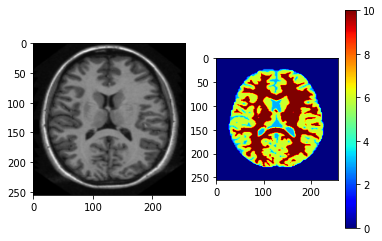

In [15]:
#Ground truth segmentation mask
image,label=test_dataset[0]#image_all[idx],label_all[idx]
image = image.unsqueeze(dim=0)
plt.figure()
plt.subplot(121)
plt.imshow(image[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(label[0],cmap='jet')
plt.colorbar()
plt.show()

In [16]:
image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
image , label = image.to(device), label.to(device)

/tmp/ipykernel_28018/3803926936.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()


### Attacking the model

#### Generating Target
There are two type of targets available:
-  __generate_target__ increases the thickness of the skull
-  __generate_target_swap__ swaps the most common classes

In [17]:
label_oh=make_one_hot(label.long(),15,device)

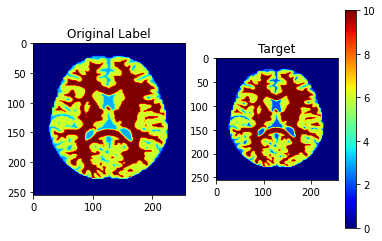

In [23]:
# Change labels from [batch_size, height, width] to [batch_size, num_classes, height, width]
# label_oh=make_one_hot(label.long(),15,device)
adv_target=generate_target_swap(label_oh.cpu().numpy())
adv_target=torch.from_numpy(adv_target).float()
adv_target=adv_target.to(device)

#Visualizing the target
_, adv=torch.max(adv_target,1)
adv=adv.cpu().numpy()
plt.figure()
plt.subplot(121)
plt.title('Original Label')
plt.imshow(label[0].cpu().numpy(),cmap='jet')
plt.subplot(122)
plt.title('Target')
plt.imshow(adv[0],cmap='jet')
plt.colorbar()
plt.show()

In [29]:
image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations= 40,#int(num_iterations),
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

Condition Reached, no gradient


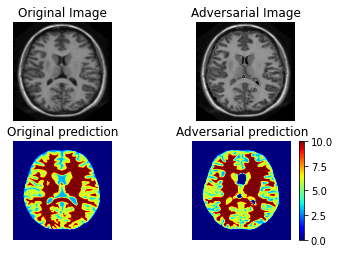

In [30]:
plt.figure()
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image_iteration[0],cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('Adversarial Image')
plt.imshow(image_iteration[-1],cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.title('Original prediction')
plt.imshow(prediction_iteration[0],cmap='jet')
plt.axis('off')
plt.subplot(224)
plt.title('Adversarial prediction')
plt.imshow(prediction_iteration[-1],cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

In [26]:
calculate_metric_percase(prediction_iteration[-1] == 6, label[0].cpu().numpy() == 6)

(0.6164442945908193, 3.1622776601683795)

In [27]:
calculate_metric_percase(prediction_iteration[-1] == 6, prediction_iteration[1] == 6)

(0.7005165017946249, 3.0)

In [ ]:
calculate_metric_percase(label[0].cpu().numpy() == 6, label[0].cpu().numpy() == 6)

(1.0, 0.0)

In [ ]:
'''
Todo: Load 2 models and transfer attack...Original prediction vs adversarial prediction
'''